# <font color="green"> Library Imports </font>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import pickle
import inflection
import matplotlib.pyplot as plt
from scikitplot.metrics import plot_cumulative_gain, plot_lift_curve

import psycopg2

from sqlalchemy import create_engine
from pycorrcat.pycorrcat         import plot_corr, corr_matrix

from imblearn.ensemble import BalancedRandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection     import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing       import MinMaxScaler, RobustScaler, LabelEncoder, OrdinalEncoder
from sklearn.ensemble            import RandomForestClassifier, ExtraTreesClassifier
from sklearn.dummy               import DummyClassifier
from sklearn.metrics             import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve
from sklearn.metrics             import accuracy_score, balanced_accuracy_score, roc_curve, auc, precision_score, f1_score, recall_score, classification_report, plot_confusion_matrix
from sklearn.linear_model        import LogisticRegression
from sklearn.neighbors           import KNeighborsClassifier

from autofeat import AutoFeatClassifier, FeatureSelector

import xgboost                   as xgb

import scipy.stats               as stats

from boruta                      import BorutaPy

import warnings

# <font color="green"> Helper functions </font>

In [2]:
def descriptive_statistics(df):
    
    df = df.select_dtypes(include=['int64', 'float64'])

    # Descriptive statistics

    df_descriptive = pd.DataFrame(data=[df.apply(np.min),
                                        df.apply(np.max),
                                        df.apply(lambda x: np.max(x) - np.min(x)),
                                        df.apply(np.mean),
                                        df.apply(np.median),
                                        df.apply(np.std),
                                        df.apply(lambda x: x.skew()),
                                        df.apply(lambda x: x.kurtosis())],
                                  index=np.array(['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']))
    
    return df_descriptive



def get_model_metrics(model_name, model, X_train, y_train, X_test, y_test):
    
    

    inst_model = model.fit(X_train, y_train)


    y_pred = inst_model.predict(X_test)


    # Metrics:



    # Accuracy

    print('Accuracy: {}\n'.format(round(accuracy_score(y_test, y_pred),3)))


    # Balanced Accuracy

    print('Balanced Accuracy: {}\n'.format(round(balanced_accuracy_score(y_test, y_pred),3)))


    # AUC ROC


    # fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1) <- sintax

    fpr, tpr, thresholds = roc_curve(y_test,
                                     np.array([i[1] for i in inst_model.predict_proba(X_test)]), 
                                     pos_label=1)

    auc(fpr, tpr)

    print('AUC-ROC: {}\n'.format(round(auc(fpr, tpr),3)))


    # Classification report

    print('Classification report:\n\n {}\n'.format(classification_report(y_test, y_pred)))


    # Gathering metrics for this estimator

    inst_model_accuracy = accuracy_score(y_test, y_pred)

    inst_model_bal_accuracy = balanced_accuracy_score(y_test, y_pred)

    inst_model_auc = auc(fpr, tpr)

    inst_model_precision = precision_score(y_test, y_pred)

    inst_model_f1 = f1_score(y_test, y_pred)

    inst_model_recall = recall_score(y_test, y_pred)
    
    
    
    # Getting df
    
    
    df = pd.DataFrame(data=[model_name, inst_model_accuracy,
                            inst_model_bal_accuracy, 
                            inst_model_auc, 
                            inst_model_precision, 
                            inst_model_f1, 
                            inst_model_recall]).transpose()

    df.columns = ['Model name', 'Accuracy', 'Balanced Accuracy', 'AUC', 'Precision', 'F1-score', 'Recall']
    
    return df  



def precision_at_k(X_test, y_test, pred_proba_model, k=1000):
    
    df_temp = pd.DataFrame()

    df_temp['id'] = X_test.index # setting id as column

    df_temp['response'] = y_test.tolist() # retrieving 'response' column
    
    df_temp['score'] = pred_proba_model[:,1].tolist() # creating 'score' column
    
    df_temp = df_temp[['id', 'score', 'response']]
    
    df_temp = df_temp.sort_values('score', ascending=False) # sorting by score
    
    df_temp['k'] = range(1, len(df_temp)+1) # creating 'k' column
    
    df_temp['precision_at_k'] = df_temp['response'].cumsum() / df_temp['k'] # calculating precision at k for each row
    
    return df_temp.loc[df_temp['k']==k, 'precision_at_k'].values[0] # selecting precision at k



def recall_at_k(X_test, y_test, pred_proba_model, k=1000):
    
    df_temp = pd.DataFrame()

    df_temp['id'] = X_test.index # setting id as column

    df_temp['response'] = y_test.tolist() # retrieving 'response' column
    
    df_temp['score'] = pred_proba_model[:,1].tolist() # creating 'score' column
    
    df_temp = df_temp[['id', 'score', 'response']]
    
    df_temp = df_temp.sort_values('score', ascending=False) # sorting by score
    
    df_temp['k'] = range(1, len(df_temp)+1) # creating 'k' column
    
    df_temp['recall_at_k'] = df_temp['response'].cumsum() / df_temp['response'].sum() # calculating recall at k for each row
    
    return df_temp.loc[df_temp['k']==k, 'recall_at_k'].values[0] # selecting precision at k



def jupyter_settings():
    
    pd.options.display.max_columns = None   
    


warnings.filterwarnings("ignore")
jupyter_settings()

# 1.0 Data import and basic inspection

## <font color="gray"> 1.1 Data loading and checking </font>

In [3]:
# Data loading

df = pd.read_csv('churn.csv')

df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [4]:
# Adjusting feature names

df.columns = list(map(lambda x: inflection.underscore(x), df.columns)) #changing to underscore + lower(snakecase)

In [5]:
# Data dimensions

print('Number of rows: {}'.format(df.shape[0]))

print('Number of columns: {}'.format(df.shape[1]))

Number of rows: 10000
Number of columns: 14


In [6]:
df

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [7]:
# Checking data info

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            10000 non-null  int64  
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [8]:
# Checking for NA's

df.isna().sum()

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

In [9]:
# Checking for duplicate rows

df.duplicated().sum()

0

In [10]:
# Response variable

df['exited'].value_counts()

0    7963
1    2037
Name: exited, dtype: int64

In [11]:
# Response variable - percentage

df['exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: exited, dtype: float64

In [12]:
# Droping 'row_number' column

df = df.drop(columns=['row_number'])

In [13]:
# Droping 'surname' column

df = df.drop(columns=['surname'])

In [14]:
# Checking the number of unique customer id's

len(df['customer_id'].unique())

10000

In [15]:
# Since each row corresponds to an unique customer we are going to set 'customer_id' row as index

df = df.set_index('customer_id')

In [16]:
df

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
customer_id,,,,,,,,,,,
15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
15606229,771,France,Male,39,5,0.00,2,1,0,96270.64,0
15569892,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
15584532,709,France,Female,36,7,0.00,1,0,1,42085.58,1


## <font color="gray"> 1.2 Descriptive statistics </font>

### <i>1.2.1 descriptive statistics</i>

In [17]:
# Numerical and categorical attributes

# numerical
num_attributes = df.select_dtypes(include=['int64', 'float64'])

# categorical
cat_attributes = df.select_dtypes(exclude=['int64', 'float64'])

In [18]:
# Descriptive statistics

descriptive_statistics(num_attributes)

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000
range,500.000000,74.000000,10.000000,250898.090000,3.000000,1.000000,1.000000,199980.900000,1.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.705500,0.515100,100090.239881,0.203700
median,652.000000,37.000000,5.000000,97198.540000,1.000000,1.000000,1.000000,100193.915000,0.000000
std,96.648466,10.487282,2.892030,62394.285254,0.581625,0.455818,0.499772,57507.617221,0.402748
skew,-0.071607,1.011320,0.010991,-0.141109,0.745568,-0.901812,-0.060437,0.002085,1.471611
kurtosis,-0.425726,1.395347,-1.165225,-1.489412,0.582981,-1.186973,-1.996747,-1.181518,0.165671


### <i>1.2.2 general view of attributes</i>

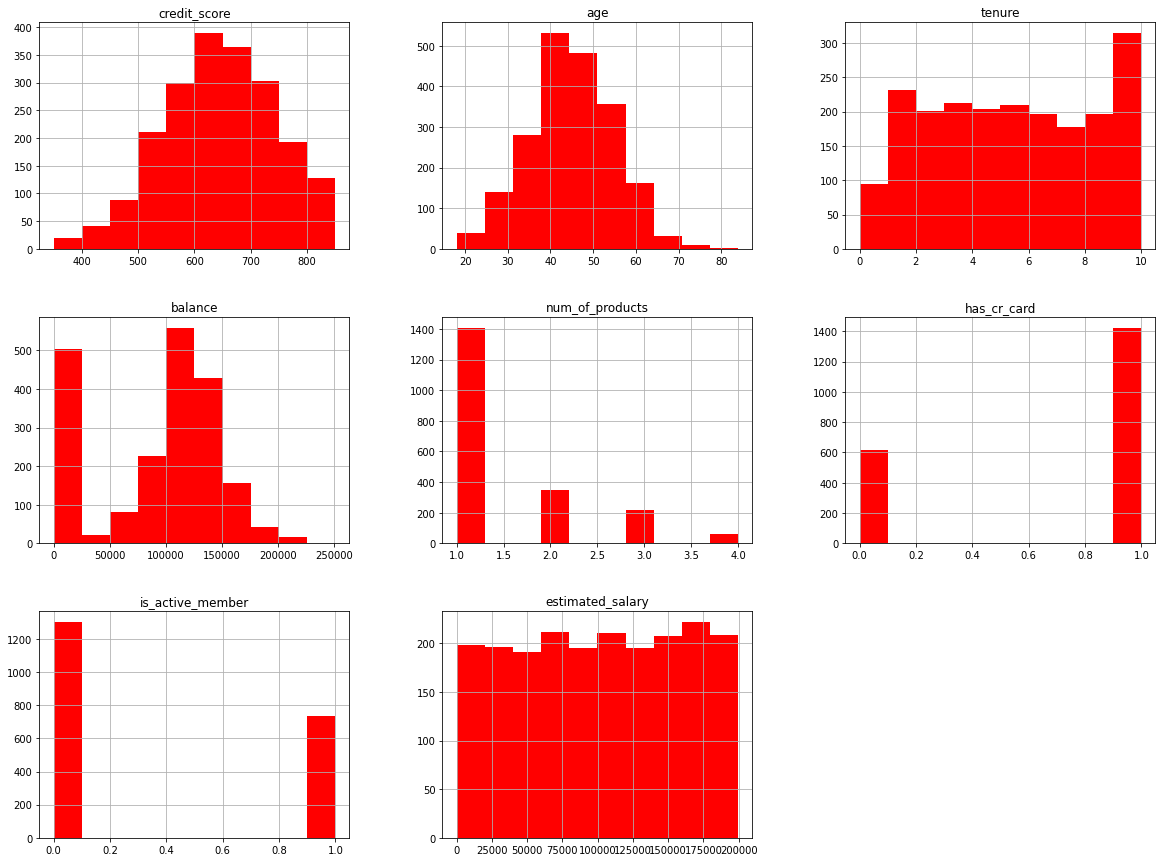

In [19]:

# Numeric attributes view

# Exploring numerical attributes

# as we are interested in people who have exited, in this evaluation we are going
# to filter the dataset based on this condition to see the behaviour of numerical attributes for this group

# we are not showing here the distribution for the numerical variable 'exited' because it is our target variable

num_attributes.loc[num_attributes['exited']==1, num_attributes.columns!='exited'].hist(figsize=(20,15), color='red');

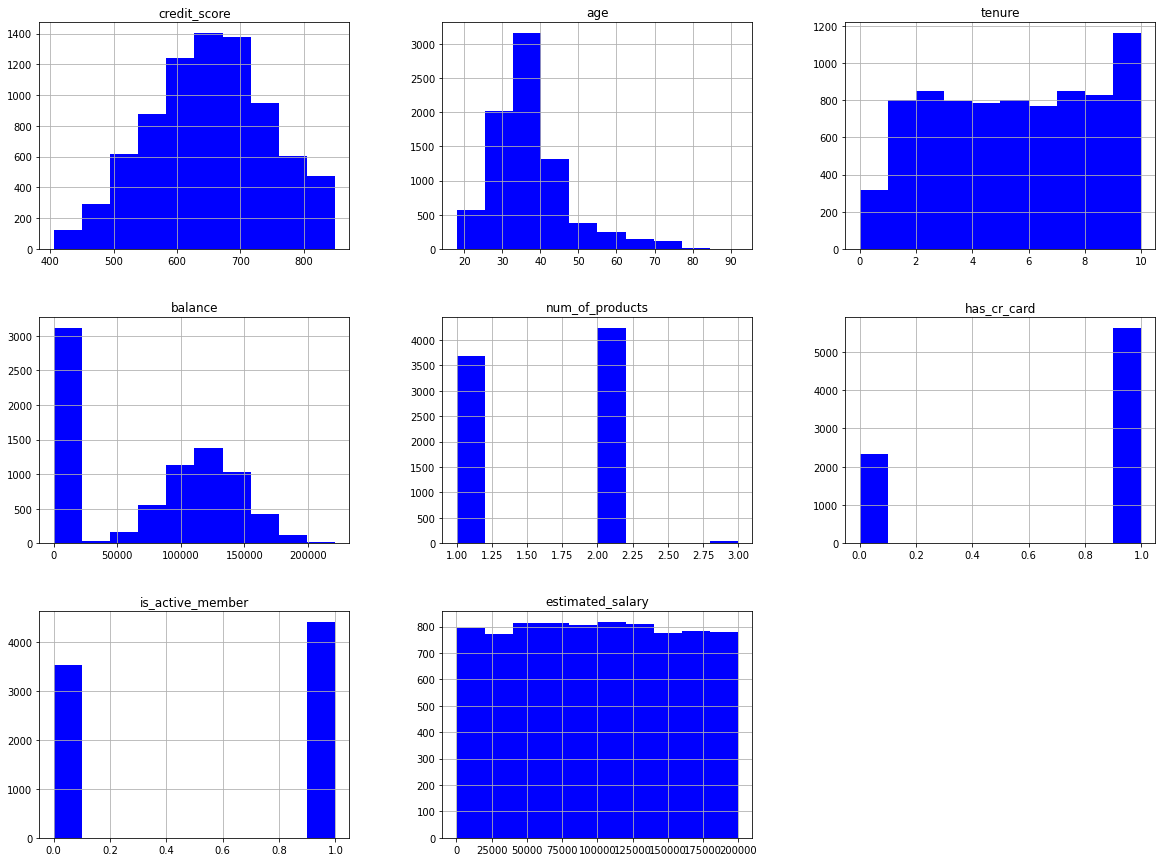

In [20]:
# Now let's compare the distributions for the same variables with people who have not exited


num_attributes.loc[num_attributes['exited']==0, num_attributes.columns!='exited'].hist(figsize=(20,15), color='blue');

* It looks like there are some differences between the two evaluated groups when looking closely at some variables like balance, num_of_products and is_active_member.

* Probably for the features where there are obvious differences this are going to help the machine learning model to figure out whether the customer is leaving or not (or the % probability of doing so).

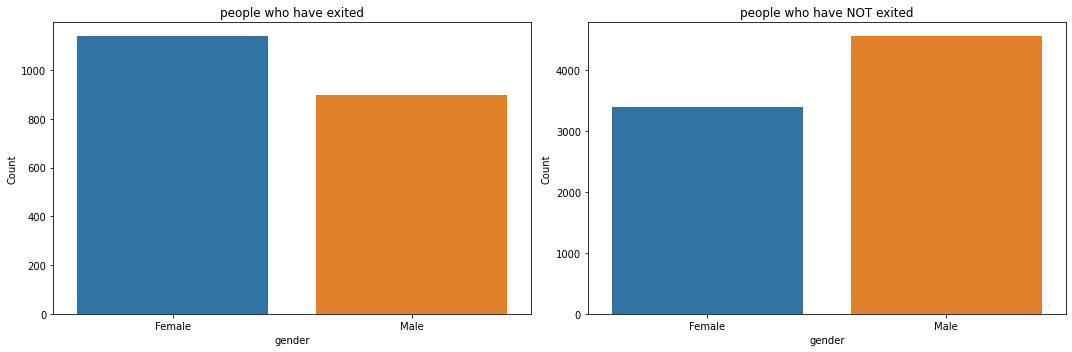

In [21]:
# Categorical attributes view


plt.figure(figsize=(15,5))

# gender profile for people who have exited

plt.subplot(1,2,1)
sns.barplot(x='gender',
            y=0,
            data=df.loc[df['exited']==1, ['gender']].groupby('gender').size().reset_index())

plt.ylabel('Count')
plt.title('people who have exited')


# gender profile for people who have not exited

plt.subplot(1,2,2)
sns.barplot(x='gender',
            y=0,
            data=df.loc[df['exited']==0, ['gender']].groupby('gender').size().reset_index())

plt.ylabel('Count')
plt.title('people who have NOT exited')

plt.tight_layout();

The female/male distribution between people who have and have not exited is different. Gender might be helpful when modeling churn behaviour. 

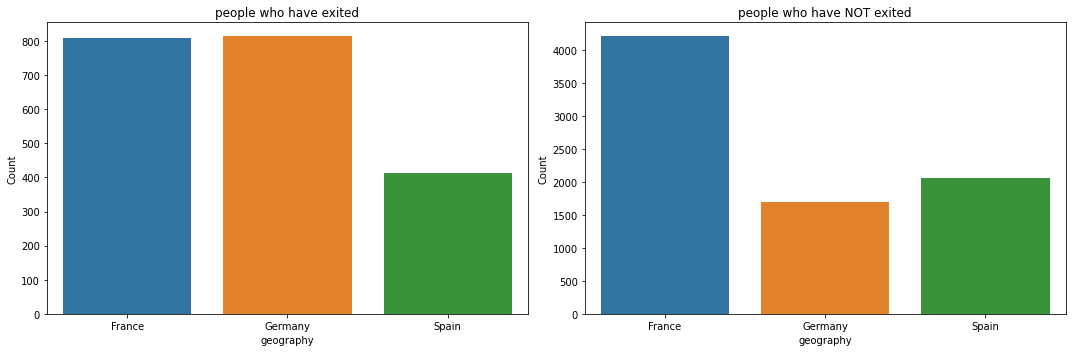

In [22]:
# Categorical attributes view


plt.figure(figsize=(15,5))

# geography profile for people who have exited

plt.subplot(1,2,1)
sns.barplot(x='geography',
            y=0,
            data=df.loc[df['exited']==1, ['geography']].groupby('geography').size().reset_index())

plt.ylabel('Count')
plt.title('people who have exited')


# geography profile for people who have not exited

plt.subplot(1,2,2)
sns.barplot(x='geography',
            y=0,
            data=df.loc[df['exited']==0, ['geography']].groupby('geography').size().reset_index())

plt.ylabel('Count')
plt.title('people who have NOT exited')

plt.tight_layout();

When looking at country distribution between customers who have and have not exited it is also possible to see differences. Therefore 'geography' might be another interesting feature to predict churn.

# 2.0 Feature engineering

In [65]:
df_2 = df.copy()

## <font color="gray"> 2.1 Creating new features </font>

In [66]:
# Creating 'age_salary_ratio' feature

df_2['age_salary_ratio'] = df_2['age']/df_2['estimated_salary']

In [67]:
# Creating 'balance_estimated_salary_ratio' feature

df_2['balance_estimated_salary_ratio'] = df_2['balance']/df_2['estimated_salary']

In [68]:
# Creating 'balance_age_ratio' feature

df_2['balance_age_ratio'] = df_2['balance']/df_2['age']

In [69]:
# Creating 'age_credit_score_ratio' feature

df_2['age_credit_score_ratio'] = df_2['age']/df_2['credit_score']

In [70]:
# Creating 'balance_credit_score_ratio' feature

df_2['balance_credit_score_ratio'] = df_2['balance']/df_2['credit_score']

In [71]:
# Creating 'tenure_credit_score_ratio' feature

df_2['tenure_credit_score_ratio'] = df_2['tenure']/df_2['credit_score']

In [72]:
# Creating 'estimated_salary_credit_score_ratio' feature

df_2['estimated_salary_credit_score_ratio'] = df_2['estimated_salary']/df_2['credit_score']

In [73]:
# Creating 'num_of_products_credit_score_ratio' feature

df_2['num_of_products_credit_score_ratio'] = df_2['num_of_products']/df_2['credit_score']

In [74]:
# Creating the feature 'stage of life' feature

df_2['stage_of_life']= df_2['age'].apply(lambda x: 'adult' if x>=20 and x<=39
                                         else 'middle_age_adult' if x>=40 and x<=59
                                         else 'senior_adult')

In [75]:
# Creating the feature 'salary_classification' feature

df_2['salary_classification']= df_2['estimated_salary'].apply(lambda x: 'above_mean' if x>110000
                                                              else 'average' if x>=90000 and x<=110000
                                                              else 'below_mean')

In [76]:
# Creating the feature 'credit_score_classification' feature

df_2['credit_score_classification']= df_2['credit_score'].apply(lambda x: 'high_score' if x>700
                                                              else 'average_score' if x>=600 and x<=700
                                                              else 'low_score')

In [77]:
# Creating the feature 'tenure_classification' feature

df_2['tenure_classification']= df_2['tenure'].apply(lambda x: 'long_term' if x>8
                                                              else 'regular' if x>=2 and x<=8
                                                              else 'short_term')

## <font color="gray"> 2.2 Hypothesis to be validated </font>

# 3.0 Data filtering

In [82]:
df_3 = df_2.copy()

In [83]:
# According to previous data visualization previously carried out (session 1.2.2) the feature 'estimated_salary' 
##  seems to beconstant and therefore do not carry useful information for group segregation. We are going to remove it

df_3 = df_3.drop(columns=['estimated_salary'])

# 4.0 Exploratory Data Analysis (EDA)

In [84]:
df_4 = df_3.copy()

## <font color="gray"> 4.1 Univariate analysis </font>

<AxesSubplot:xlabel='exited', ylabel='count'>

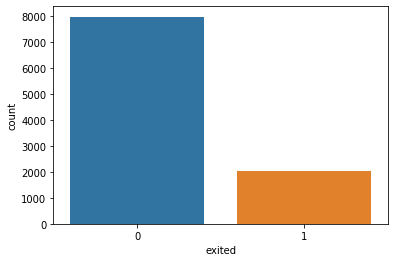

In [85]:
# Response variable

sns.countplot(df_4['exited'])

### <i>4.1.1 numerical attributes</i>

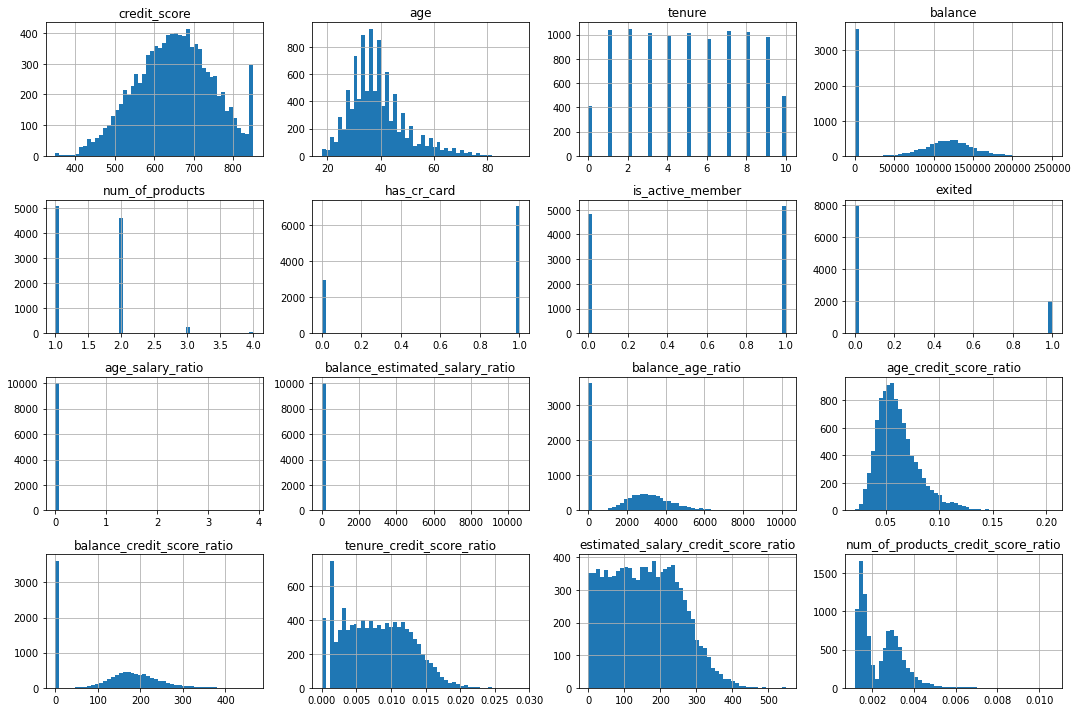

In [86]:
df_4.select_dtypes(['float64', 'int64']).hist(figsize=(15,10), bins=50);
plt.tight_layout()

### <i>4.1.2 categorical attributes</i>

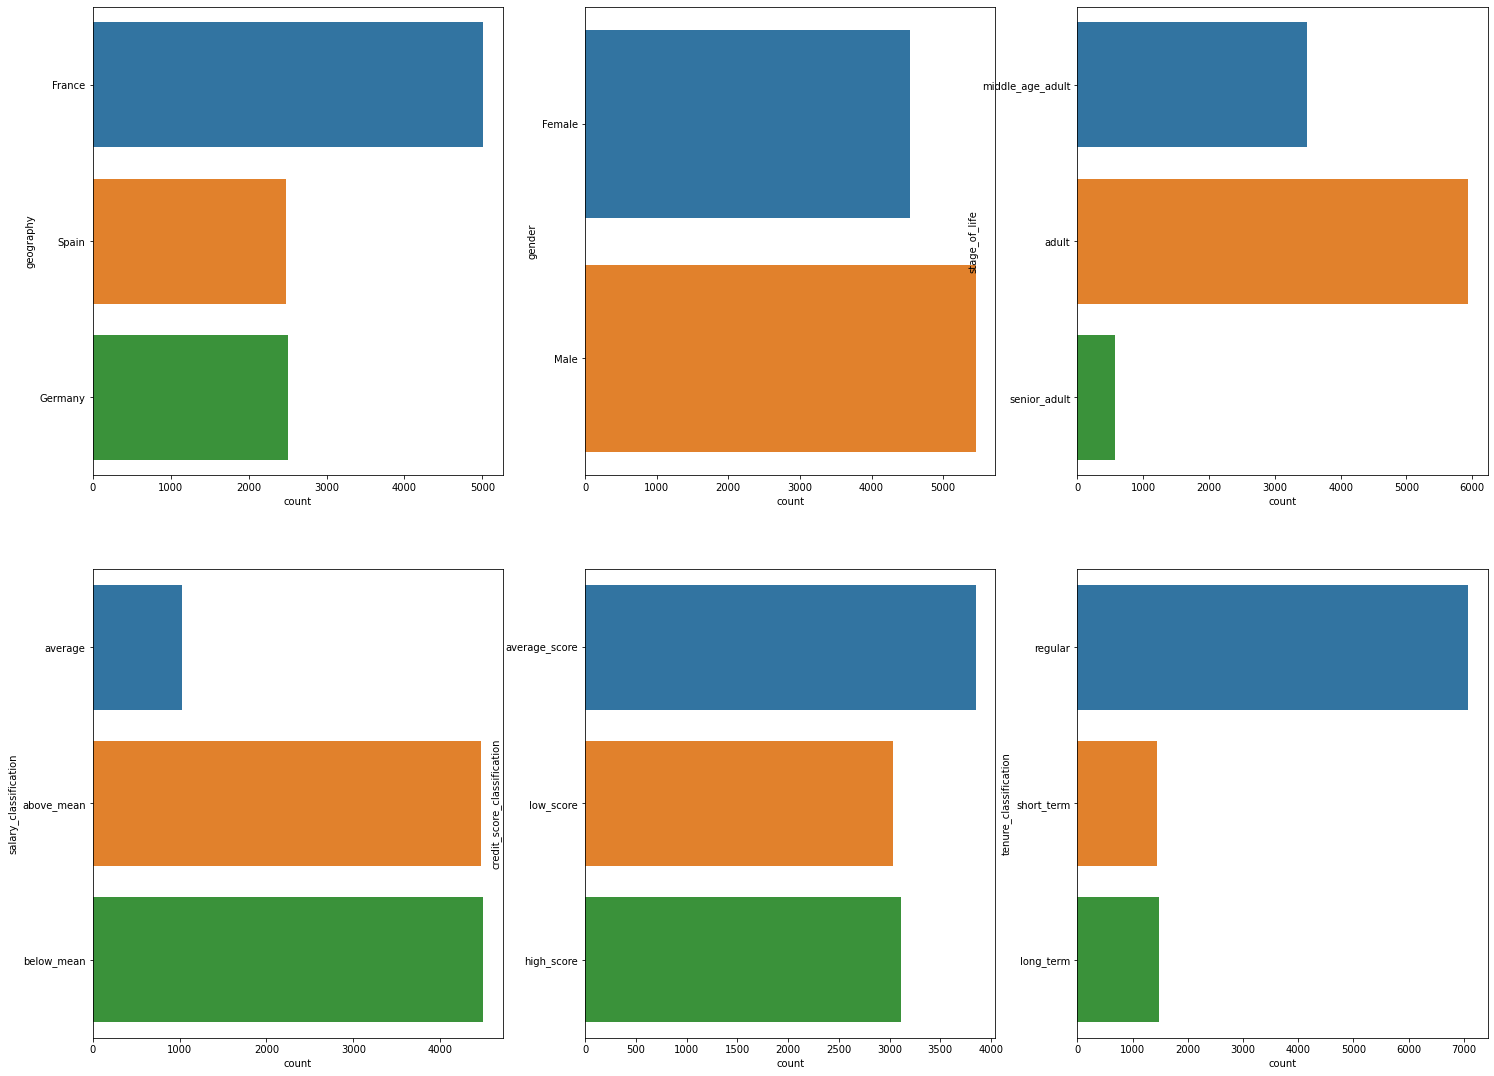

In [117]:
# sets plot size
plt.figure(figsize=(25, 50))

# sets the inital plot position
n = 1

# iterates over the columns to plot
for i in df_4.select_dtypes(exclude=['float64', 'int64']).columns:
    plt.subplot(5, 3, n)
    _ = sns.countplot(y=df_4.select_dtypes(exclude=['float64', 'int64'])[i], orient='v')
    n += 1


# # display the plot
plt.show()

## <font color="gray"> 4.2 Bivariate analysis </font>

### <i>4.2.1 validating hypothesis raised</i>

### <i>4.2.2 statistical hypothesis testing</i>

It will be applied to numeric continuous attributes:

       'balance', 'age_salary_ratio', 'balance_estimated_salary_ratio',
       'balance_age_ratio', 'age_credit_score_ratio',
       'balance_credit_score_ratio', 'tenure_credit_score_ratio',
       'estimated_salary_credit_score_ratio',
       'num_of_products_credit_score_ratio'

But first let's test to check if the data distribution of these features has a gaussian shape (parametric distribution) so we can further apply the correct statistical test.

In [118]:
# Shapiro test

for i in df_4.select_dtypes(include=['float64']).columns:

    stat, p = stats.shapiro(df_4.loc[:, i])
    
    print('Feature: {}'.format(i))
    print('stat=%.3f, p=%.3f' % (stat, p))

    if p > 0.05:
        print('Probably Gaussian\n')

    else:
        print('Probably not Gaussian\n')

Feature: balance
stat=0.846, p=0.000
Probably not Gaussian

Feature: age_salary_ratio
stat=0.014, p=0.000
Probably not Gaussian

Feature: balance_estimated_salary_ratio
stat=0.009, p=0.000
Probably not Gaussian

Feature: balance_age_ratio
stat=0.888, p=0.000
Probably not Gaussian

Feature: age_credit_score_ratio
stat=0.936, p=0.000
Probably not Gaussian

Feature: balance_credit_score_ratio
stat=0.872, p=0.000
Probably not Gaussian

Feature: tenure_credit_score_ratio
stat=0.974, p=0.000
Probably not Gaussian

Feature: estimated_salary_credit_score_ratio
stat=0.975, p=0.000
Probably not Gaussian

Feature: num_of_products_credit_score_ratio
stat=0.900, p=0.000
Probably not Gaussian



Since these features probably does not have a Gaussian shape we will apply Mann-Whitney non-parametric test:

In [115]:
for i in df_4.select_dtypes(include=['float64']).columns:

    stat, p = stats.mannwhitneyu(df_4.loc[df_4['exited']==0, i], 
                                 df_4.loc[df_4['exited']==1, i])
    
    print('Feature: {}'.format(i))
    print('stat=%.3f, p=%.3f' % (stat, p))

    if p > 0.05:
        print('Probably the same distribution\n')

    else:
        print('Probably different distributions\n')

Feature: balance
stat=6849444.500, p=0.000
Probably different distributions

Feature: age_salary_ratio
stat=7024933.000, p=0.000
Probably different distributions

Feature: balance_estimated_salary_ratio
stat=6930793.000, p=0.000
Probably different distributions

Feature: balance_age_ratio
stat=8008861.000, p=0.371
Probably the same distribution

Feature: age_credit_score_ratio
stat=4866734.000, p=0.000
Probably different distributions

Feature: balance_credit_score_ratio
stat=6753011.000, p=0.000
Probably different distributions

Feature: tenure_credit_score_ratio
stat=8224942.500, p=0.324
Probably the same distribution

Feature: estimated_salary_credit_score_ratio
stat=7877744.000, p=0.045
Probably different distributions

Feature: num_of_products_credit_score_ratio
stat=9303612.500, p=0.000
Probably different distributions



Checking the agreement between statistical test results and boxplots:

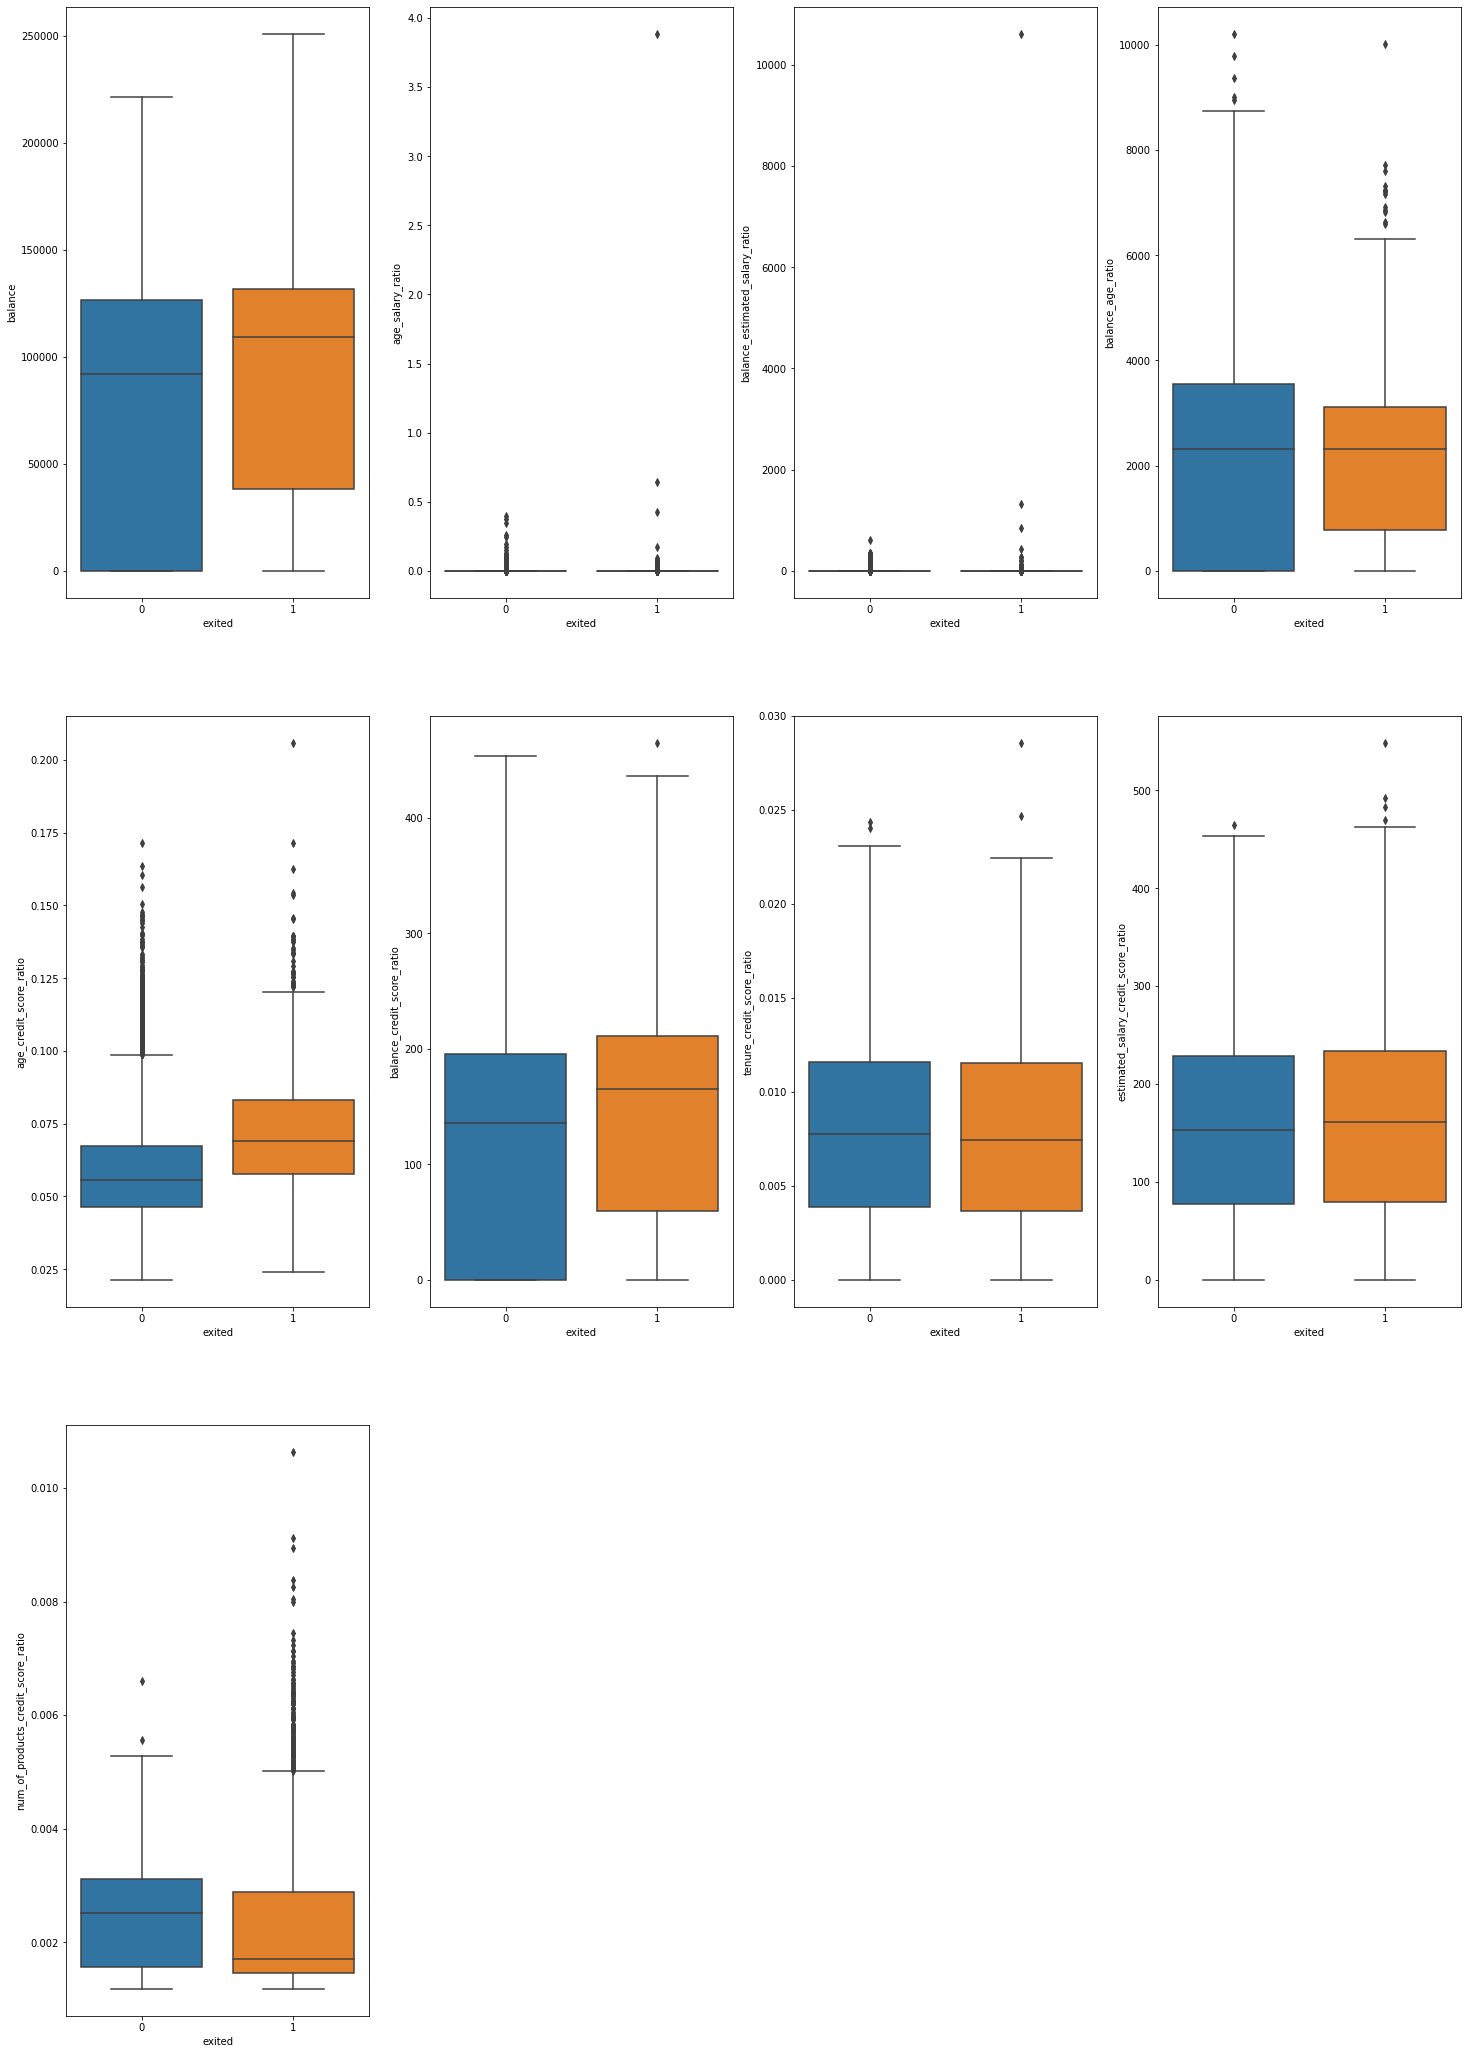

In [123]:
# sets plot size
plt.figure(figsize=(25, 50))

# sets the inital plot position
n = 1

for i in df_4.select_dtypes(include=['float64']).columns:
    
    plt.subplot(4, 4, n)
    sns.boxplot(x='exited', y=i, data=df_4)
    n += 1
    
# # display the plot
plt.show()

## <font color="gray"> 4.3 Multivariate analysis </font>

### <i>4.3.1 numerical attributes</i>

<AxesSubplot:>

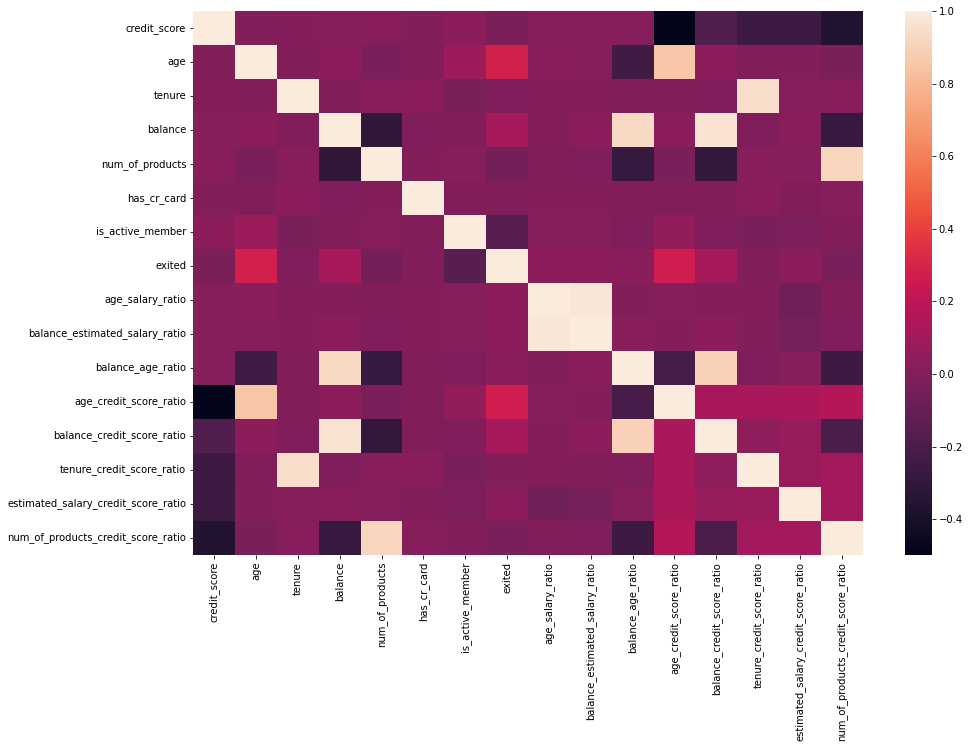

In [124]:
# Correlation analysis

plt.figure(figsize=(15,10))

sns.heatmap(df_4.select_dtypes(include=['float64', 'int64']).corr())

### <i>4.3.2 categorical attributes</i>

<AxesSubplot:>

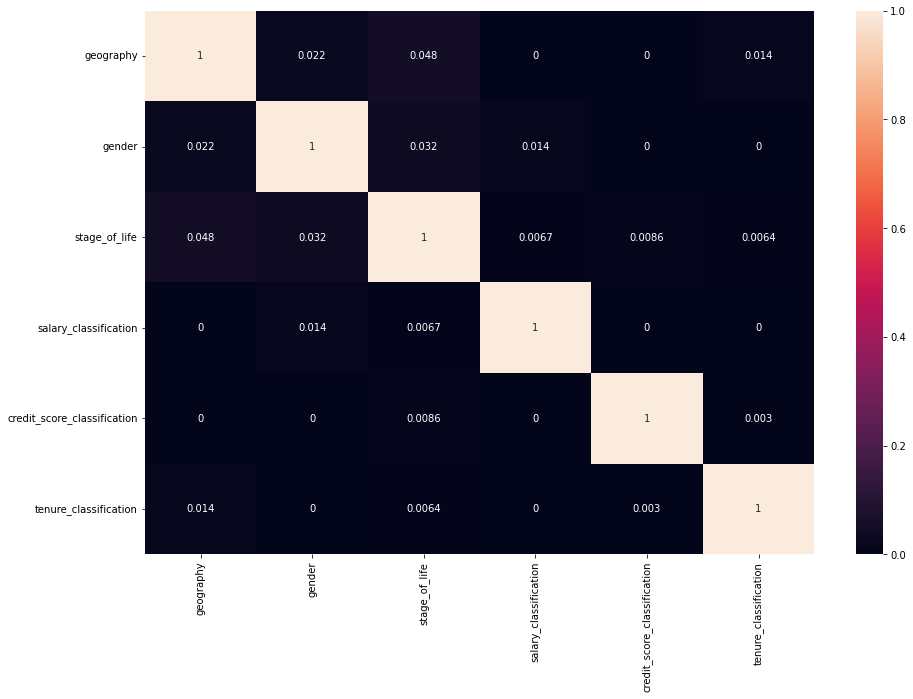

In [125]:
# Correlation analysis

plt.figure(figsize=(15,10))

plot_corr(df_4,
          df_4.select_dtypes(exclude=['float64', 'int64']).columns)

# 5.0 Data preparation

In [126]:
df_5 = df_4.copy()

## <font color="gray"> 5.1 Train/Test split </font>

In [195]:
# Train/Test split

# X_train, X_test, y_train, y_test = train_test_split(y, X, test_size=0.33, random_state=42) <- sintax

y_train, y_test, X_train, X_test = train_test_split(df_5['exited'], 
                                                    df_5.drop(columns=['exited']), 
                                                    test_size=0.33, 
                                                    random_state=42,
                                                    stratify=df_5['exited'])

In [176]:
# Checking class proportion - Training set

y_train.value_counts(normalize=True)

0    0.796269
1    0.203731
Name: exited, dtype: float64

In [177]:
# Checking class proportion - Testing set

y_test.value_counts(normalize=True)

0    0.796364
1    0.203636
Name: exited, dtype: float64

In [178]:
# Reminding class proportion - Original data

df['exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: exited, dtype: float64

## <font color="gray"> 5.2 Scaling - numerical attributes </font>

In [196]:

# Scaling 'credit_score' - MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train[['credit_score']].values)

X_train['credit_score'] = scaler.transform(X_train[['credit_score']].values) # scaling train
X_test['credit_score'] = scaler.transform(X_test[['credit_score']].values) # scaling test

In [197]:
# Scaling 'age' - RobustScaler

scaler = RobustScaler()

scaler.fit(X_train[['age']].values)

X_train['age'] = scaler.transform(X_train[['age']].values) # scaling train
X_test['age'] = scaler.transform(X_test[['age']].values) # scaling test

In [198]:
# Scaling 'tenure' - MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train[['tenure']].values)

X_train['tenure'] = scaler.transform(X_train[['tenure']].values) # scaling train
X_test['tenure'] = scaler.transform(X_test[['tenure']].values) # scaling test

In [199]:
# Scaling 'balance' - MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train[['balance']].values)

X_train['balance'] = scaler.transform(X_train[['balance']].values) # scaling train
X_test['balance'] = scaler.transform(X_test[['balance']].values) # scaling test

In [200]:
# Scaling 'num_of_products' - RobustScaler

scaler = RobustScaler()

scaler.fit(X_train[['num_of_products']].values)

X_train['num_of_products'] = scaler.transform(X_train[['num_of_products']].values) # scaling train
X_test['num_of_products'] = scaler.transform(X_test[['num_of_products']].values) # scaling test

In [201]:
# Scaling 'age_salary_ratio' - MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train[['age_salary_ratio']].values)

X_train['age_salary_ratio'] = scaler.transform(X_train[['age_salary_ratio']].values) # scaling train
X_test['age_salary_ratio'] = scaler.transform(X_test[['age_salary_ratio']].values) # scaling test

In [202]:
# Scaling 'balance_estimated_salary_ratio' - MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train[['balance_estimated_salary_ratio']].values)

X_train['balance_estimated_salary_ratio'] = scaler.transform(X_train[['balance_estimated_salary_ratio']].values) # scaling train
X_test['balance_estimated_salary_ratio'] = scaler.transform(X_test[['balance_estimated_salary_ratio']].values) # scaling test

In [ ]:
# Scaling 'balance_age_ratio' - MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train[['balance_age_ratio']].values)

X_train['balance_age_ratio'] = scaler.transform(X_train[['balance_age_ratio']].values) # scaling train
X_test['balance_age_ratio'] = scaler.transform(X_test[['balance_age_ratio']].values) # scaling test

In [212]:
# Scaling 'age_credit_score_ratio' - MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train[['age_credit_score_ratio']].values)

X_train['age_credit_score_ratio'] = scaler.transform(X_train[['age_credit_score_ratio']].values) # scaling train
X_test['age_credit_score_ratio'] = scaler.transform(X_test[['age_credit_score_ratio']].values) # scaling test

In [217]:
# Scaling 'balance_credit_score_ratio' - MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train[['balance_credit_score_ratio']].values)

X_train['balance_credit_score_ratio'] = scaler.transform(X_train[['balance_credit_score_ratio']].values) # scaling train
X_test['balance_credit_score_ratio'] = scaler.transform(X_test[['balance_credit_score_ratio']].values) # scaling test

In [222]:
# Scaling 'tenure_credit_score_ratio' - MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train[['tenure_credit_score_ratio']].values)

X_train['tenure_credit_score_ratio'] = scaler.transform(X_train[['tenure_credit_score_ratio']].values) # scaling train
X_test['tenure_credit_score_ratio'] = scaler.transform(X_test[['tenure_credit_score_ratio']].values) # scaling test

In [227]:
# Scaling 'estimated_salary_credit_score_ratio' - RobustScaler

scaler = RobustScaler()

scaler.fit(X_train[['estimated_salary_credit_score_ratio']].values)

X_train['estimated_salary_credit_score_ratio'] = scaler.transform(X_train[['estimated_salary_credit_score_ratio']].values) # scaling train
X_test['estimated_salary_credit_score_ratio'] = scaler.transform(X_test[['estimated_salary_credit_score_ratio']].values) # scaling test

In [232]:
# Scaling 'num_of_products_credit_score_ratio' - MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train[['num_of_products_credit_score_ratio']].values)

X_train['num_of_products_credit_score_ratio'] = scaler.transform(X_train[['num_of_products_credit_score_ratio']].values) # scaling train
X_test['num_of_products_credit_score_ratio'] = scaler.transform(X_test[['num_of_products_credit_score_ratio']].values) # scaling test

## <font color="gray"> 5.3 Encoding - categorical attributes </font>

# 6.0 Feature selection

## <font color="gray"> 6.1 Boruta algorithm </font>

## <font color="gray"> 6.2 Columns selected by Boruta</font>

# 7.0 Machine learning

## <font color="gray"> 7.1 Baseline model </font>

## <font color="gray"> 7.2 Logistic Regression </font>

## <font color="gray"> 7.3 Random Forest </font>

## <font color="gray"> 7.4 XGBoost </font>

## <font color="gray"> 7.5 KNN </font>

Cross validation

# 8.0 Hyperparameter fine tuning

## <font color="gray"> 8.1 Random search </font>

## <font color="gray"> 8.2 Tuned final model </font>

# 9.0 Error interpretation

## <font color="gray"> 9.1 Main </font>

# 10.0 Deploy

## <font color="gray"> 10.1 Class data_prep.py </font>

## <font color="gray"> 10.2 API_handler.py </font>

## <font color="gray"> 10.3 API tester local </font>

## <font color="gray"> 10.4 API tester remote/cloud </font>